#KDD(Knowledge Discovery in Databases)

##Selecionando os Dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

In [ ]:
df_orders = pd.read_excel('/content/drive/MyDrive/AB-Inbev_Case/Dados Brutos/orders.xlsx')
df_orders.head(5)

,order_id,order_date,user_id,product_id,revenue
0,8213351680,2024-08-02,75361105,32189,3110.96
1,7536474509,2024-10-29,43580092,60146,645.26
2,5205005404,2024-03-07,75361105,50781,844.18
3,8213351680,2024-08-02,75361105,21032,3110.96
4,2673322804,2024-02-28,75361105,44933,3380.05


In [ ]:
df_items = pd.read_excel('/content/drive/MyDrive/AB-Inbev_Case/Dados Brutos/items.xlsx')
df_items.head(5)

,item_id,category
0,61999,beer
1,2395,nab
2,49121,beer
3,2960,beer
4,65448,beer


In [ ]:
df_targets = pd.read_excel('/content/drive/MyDrive/AB-Inbev_Case/Dados Brutos/targets.xlsx')
df_targets.head(5)

,user_id,category,city,monthly revenue target
0,10560208,restaurant,São Paulo,3000
1,33198146,restaurant,Rio de Janeiro,7000
2,37404863,restaurant,Rio de Janeiro,75000
3,43580092,bar,São Paulo,5000
4,75361105,bar,Campinas,150000


In [ ]:
df_users = pd.read_excel('/content/drive/MyDrive/AB-Inbev_Case/Dados Brutos/users.xlsx')
df_users.head(5)

,user_id,category,city
0,75361105,bar,Campinas
1,43580092,bar,São Paulo
2,37404863,restaurant,Rio de Janeiro
3,10560208,restaurant,São Paulo
4,86808677,bar,São Paulo


## Pré Processamento dos dados

In [ ]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_id    1651 non-null   int64         
 1   order_date  1651 non-null   datetime64[ns]
 2   user_id     1651 non-null   int64         
 3   product_id  1651 non-null   int64         
 4   revenue     1651 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 64.6 KB


In [ ]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item_id   314 non-null    int64 
 1   category  314 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.0+ KB


In [ ]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user_id                 8 non-null      int64 
 1   category                8 non-null      object
 2   city                    8 non-null      object
 3   monthly revenue target  8 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 388.0+ bytes


In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   8 non-null      int64 
 1   category  8 non-null      object
 2   city      8 non-null      object
dtypes: int64(1), object(2)
memory usage: 324.0+ bytes


Conforme observado via powerQuery, as etapas de pré processamento já estão validadas. Mas abaixo deixo as possiveis tratativas para limpeza caso tivesse incosistencias.

In [ ]:
# Converter colunas para os tipos corretos caso precisasse
# df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])
# df_orders['revenue'] = df_orders['revenue'].astype(float)

# Remover valores nulos
# df_orders.dropna(inplace=True)

# Remvoer valores duplicados
# df = df.drop_duplicates(subset=['', ''], keep='first')

## Transformação

In [ ]:
# Criando DataFrame agregado para análise de correlação
df_agg = df_orders.groupby('user_id').agg(
    GMV=('revenue', 'sum'),
    total_orders=('order_id', 'nunique'), #QTDTotal de pedidos
    avg_order_value=('revenue', 'mean'),  #Ticket Medio
    median_order_value = ('revenue','median') #Mediana por pedido
).reset_index()

# Juntar com as metas de receita
df_agg = df_agg.merge(df_targets, on='user_id', how='left')

# Calcular % de atingimento da meta
df_agg['target_achievement'] = df_agg['GMV'] / df_agg['monthly revenue target']

# Selecionando somente variaveis do tipo numero
df_corr = df_agg.select_dtypes(include=['number'])



In [ ]:
#Criando coluna de ano e mês para analisar serie temporal
df_orders['year_month'] = df_orders['order_date'].dt.to_period('M')

## Data Mining

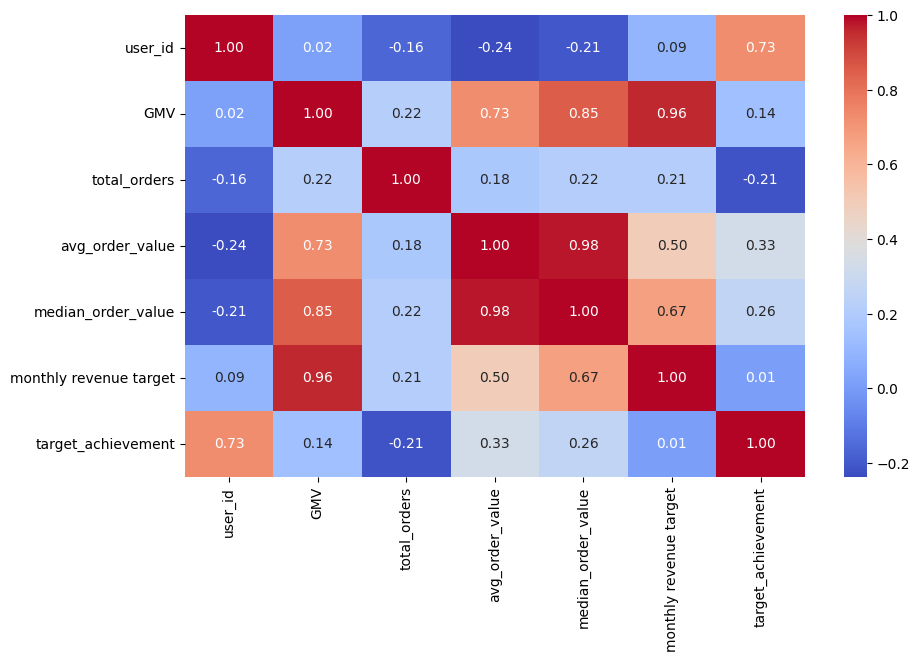

In [ ]:
# Entendimento da correlação das variaveis para levantamento de perguntas relevantes ao negocio
corr_matrix = df_corr.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


De acordo com a matriz de correlação, podemos observar:


1.   GMV tem uma correlação muito forte(0.96) com a meta mensal, indicando que quanto mais a meta for atingida irá impactar positivamente no GMV
2.   GMV tem uma correlação forte(0.85,0.73) com a média e mediana dos pedidos, indicando que quanto maior aumento da média e mediana dos pedidos maior impacto no GMV
3.  O cumprimento da meta(target_achievement) com user_id tem uma correlação forte(0.73) indicando que usuarios que compram contribuem para o atingimento da meta

Como resultado podemos levantar as seguintes perguntas relevantes para o negócio:

 1. Quais são os produtos que mais venderam e contribuiram com o cumprimento da meta?
 2. Quais são as categorias de produtos que mais contribuiram para o cumprimento da meta?
 3. Qual foi o usuário que mais contribuiu para o cumprimento da meta?
 4. Qual foi a região que mais contribuiu para o cumprimento da meta?
 5. Verificado que existe uma diferença de correlação do GMV com a média e mediana, analisar a existencia de outliers



<ipython-input-96-f50297eccc89>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_products.values, y=top_products.index.astype(str), palette='viridis')


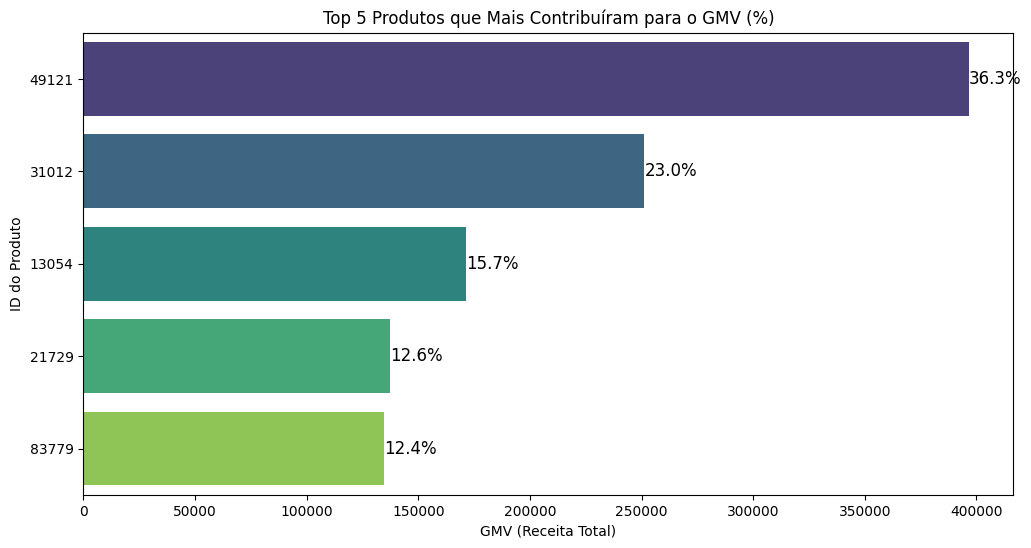

In [ ]:
plt.figure(figsize=(12, 6))

# Agrupar os top 5 produtos por GMV
top_products = df_orders.groupby('product_id')['revenue'].sum().nlargest(5)
total_gmv = top_products.sum()
percentages = (top_products / total_gmv) * 100

#Convertendo a variavel top_products para string a fim de evitar erros no gráfico de barras

ax = sns.barplot(x=top_products.values, y=top_products.index.astype(str), palette='viridis')

# Adicionando os percentuais nas barras
for i, (value, percentage) in enumerate(zip(top_products.values, percentages)):
    ax.text(value, i, f"{percentage:.1f}%", va='center', ha='left', fontsize=12, color='black')

plt.xlabel("GMV (Receita Total)")
plt.ylabel("ID do Produto")
plt.title("Top 5 Produtos que Mais Contribuíram para o GMV (%)")
plt.show()


Podemos ver que os produtos com ids: 49121,31012 e 13054 são os principais que contribuiram para o GMV. Como ponto de possivel melhoria para alavancar os outros seria analisar se as vendas estão segmentadas da forma correta para possivel campanha de impulsionamento e promoções.

<ipython-input-11-137be73a821c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_gmv.index.astype(str), y=category_gmv.values, palette='coolwarm')


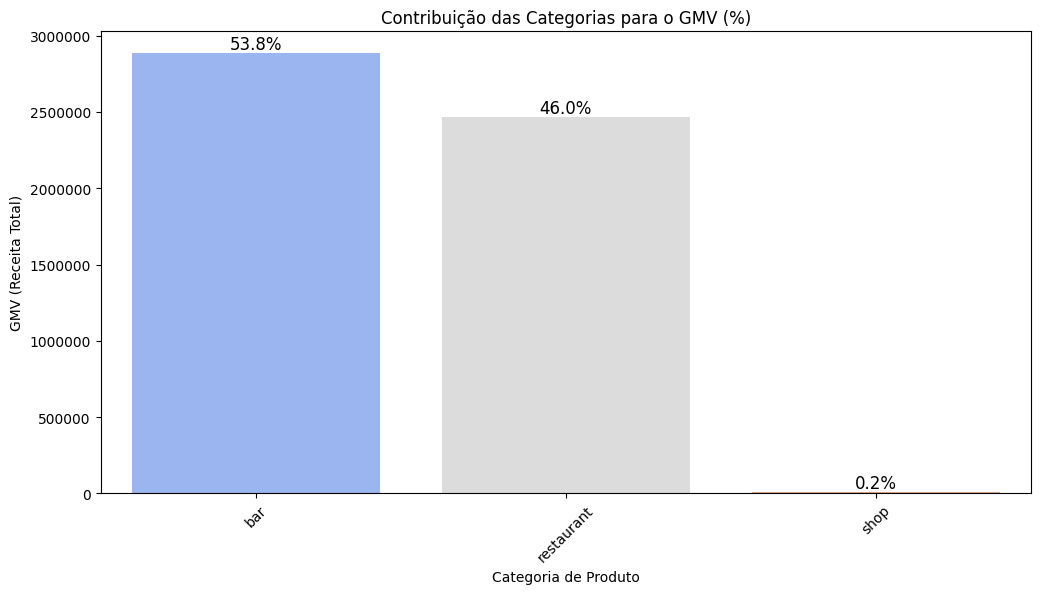

In [ ]:
plt.figure(figsize=(12, 6))
category_gmv = df_agg.groupby('category')['GMV'].sum().sort_values(ascending=False)
total_gmv = category_gmv.sum()
percentages = (category_gmv / total_gmv) * 100

ax = sns.barplot(x=category_gmv.index.astype(str), y=category_gmv.values, palette='coolwarm')

# Adicionando os percentuais nas barras
for i, (value, percentage) in enumerate(zip(category_gmv.values, percentages)):
    ax.text(i, value, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=12, color='black')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))

plt.xlabel("Categoria de Produto")
plt.ylabel("GMV (Receita Total)")
plt.title("Contribuição das Categorias para o GMV (%)")
plt.xticks(rotation=45)
plt.show()


Podemos analisar que bares e restaurantes somados atingem 99.8% da meta. Com isso poderiamos pensar em conjunto dos times comerciais, marketing e operações formas de alavancar as vendas para categoria shop.

<ipython-input-14-22d6af9aa49d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_clients.values, y=top_clients.index.astype(str), palette='magma')  # Convertendo IDs para string


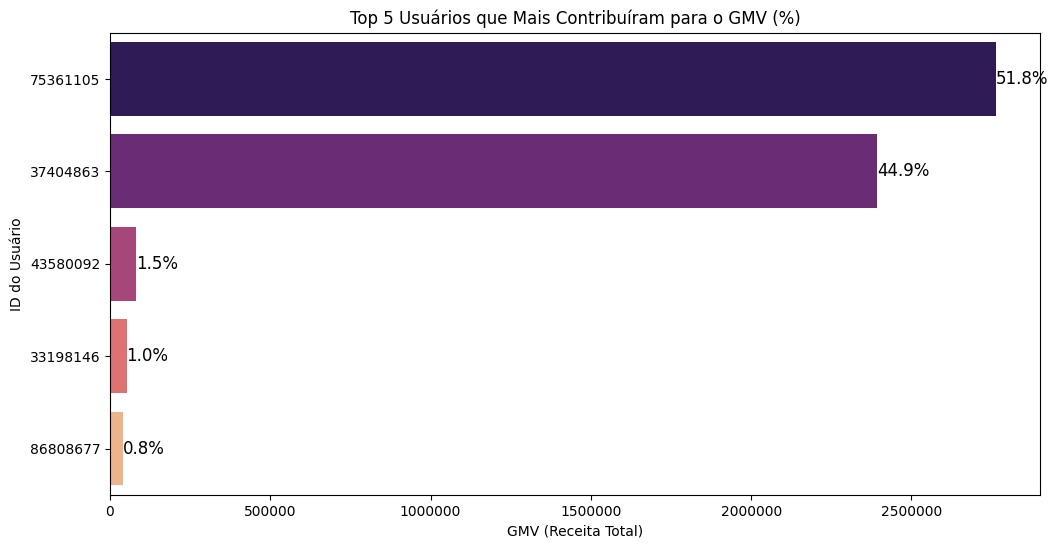

In [ ]:
plt.figure(figsize=(12, 6))

# Filtrar apenas os Top 5 Usuarios
top_clients = df_agg.groupby('user_id')['GMV'].sum().nlargest(5)
total_gmv = top_clients.sum()
percentages = (top_clients / total_gmv) * 100

ax = sns.barplot(x=top_clients.values, y=top_clients.index.astype(str), palette='magma')  # Convertendo IDs para string

# Adicionando os percentuais nas barras
for i, (value, percentage) in enumerate(zip(top_clients.values, percentages)):
    ax.text(value, i, f"{percentage:.1f}%", va='center', ha='left', fontsize=12, color='black')

# Formatando o eixo X para exibir números inteiros
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))

plt.xlabel("GMV (Receita Total)")
plt.ylabel("ID do Usuário")
plt.title("Top 5 Usuários que Mais Contribuíram para o GMV (%)")
plt.show()


Podemos analisar que os usuarios 75361105 e 37404863 lideram o ranking, como levantando anteriormente é necessario analisar em conjunto com as áreas de negócios se esses clientes são outliers.

<ipython-input-15-712546924568>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=city_gmv.index, y=city_gmv.values, palette='rocket')


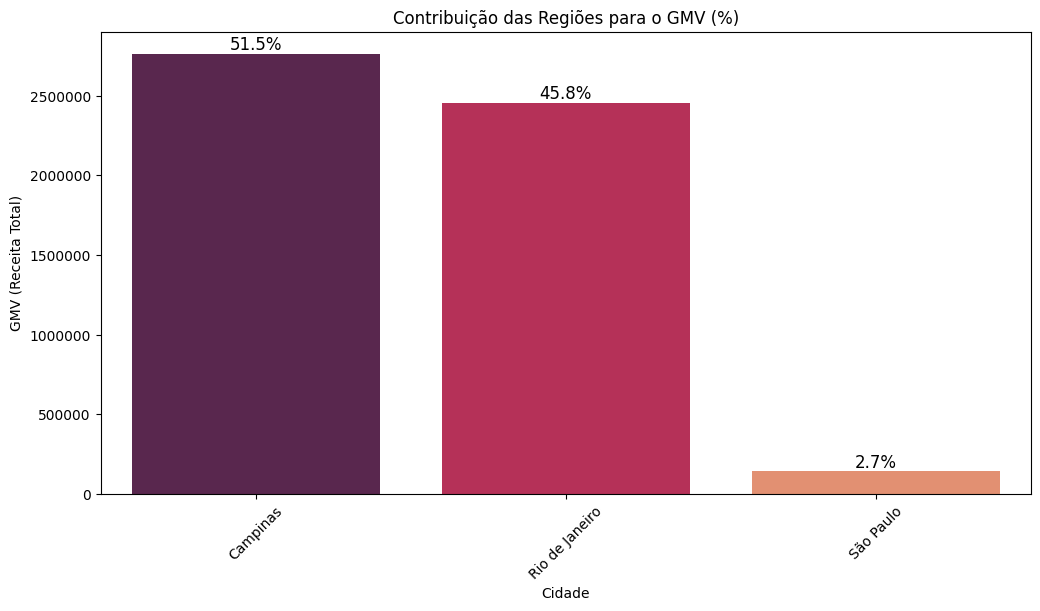

In [ ]:
plt.figure(figsize=(12, 6))
city_gmv = df_agg.groupby('city')['GMV'].sum().sort_values(ascending=False)
total_gmv = city_gmv.sum()
percentages = (city_gmv / total_gmv) * 100

ax = sns.barplot(x=city_gmv.index, y=city_gmv.values, palette='rocket')

# Adicionando os percentuais nas barras
for i, (value, percentage) in enumerate(zip(city_gmv.values, percentages)):
    ax.text(i, value, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=12, color='black')

# Formatando o eixo Y para exibir números inteiros
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))

plt.xlabel("Cidade")
plt.ylabel("GMV (Receita Total)")
plt.title("Contribuição das Regiões para o GMV (%)")
plt.xticks(rotation=45)
plt.show()

Campinas e Rio de janeiro lideram em GMV, como ponto de melhoria: Analisar quais produtos podem ser impulsionados na cidade de São Paulo e analise de leads residentes em São Paulo

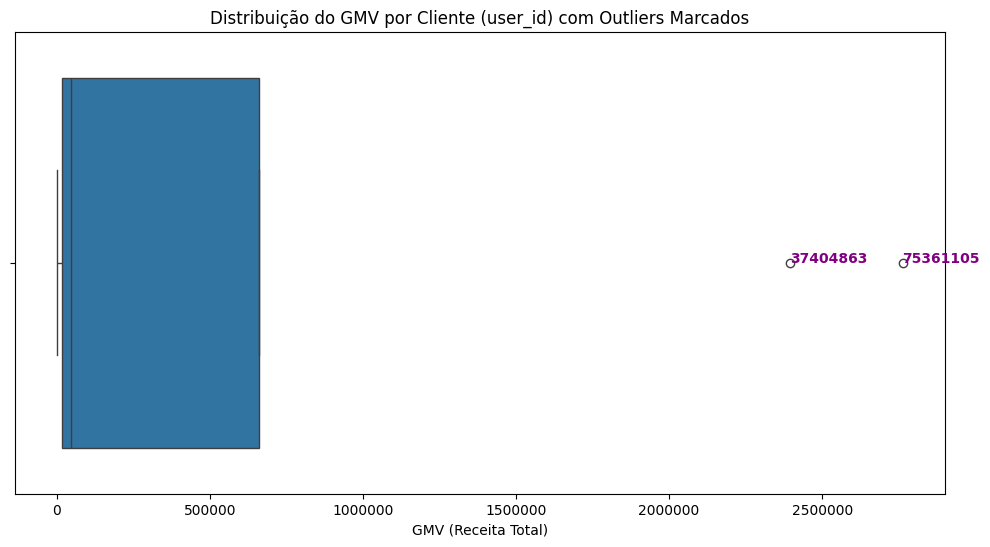

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x=df_agg['GMV'])

Q1 = df_agg['GMV'].quantile(0.25)
Q3 = df_agg['GMV'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_agg[df_agg['GMV'] > (Q3 + 1.5 * IQR)]

for i, row in outliers.iterrows():
    ax.text(row['GMV'], 0, f"{row['user_id']}",
            horizontalalignment='left', size=10, color='purple', weight='semibold')

# Formatando o eixo X para exibir números inteiros
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))

plt.xlabel("GMV (Receita Total)")
plt.title("Distribuição do GMV por Cliente (user_id) com Outliers Marcados")
plt.show()


Identificado que os usuarios(user_id) 37404863 e 75361105 estão classificados como outlier no boxplot, para validar melhor podemos construir um gráfico de linhas para analisar a serie temporal desse evento.

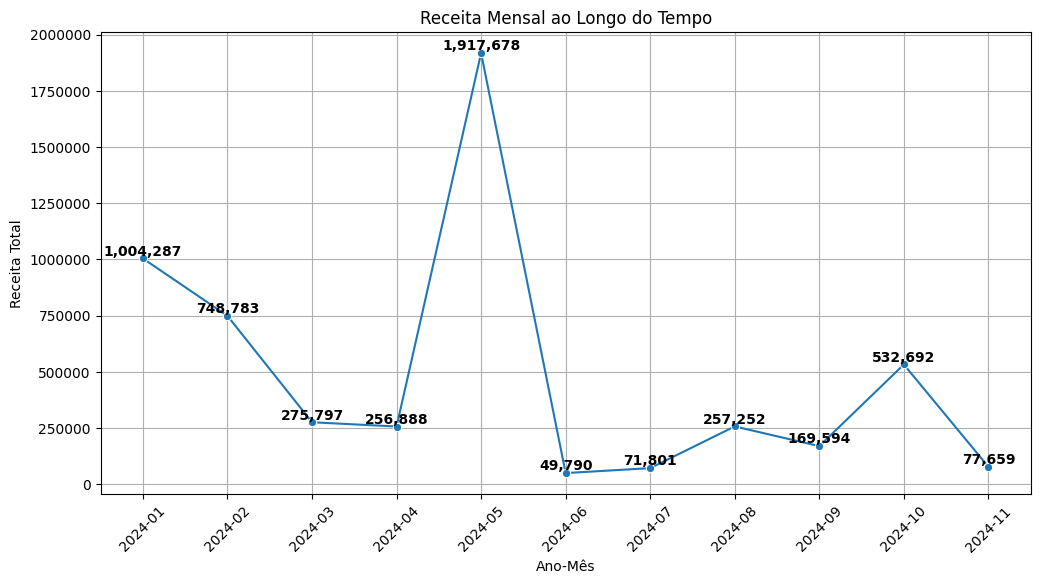

In [ ]:
monthly_revenue = df_orders.groupby('year_month')['revenue'].sum().reset_index()
monthly_revenue['year_month'] = monthly_revenue['year_month'].astype(str)


plt.figure(figsize=(12,6))
ax = sns.lineplot(data=monthly_revenue, x='year_month', y='revenue', marker='o')

for x, y in zip(monthly_revenue['year_month'], monthly_revenue['revenue']):
    ax.text(x, y, f"{y:,.0f}", ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Formatando o eixo Y para exibir números inteiros
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))

plt.title("Receita Mensal ao Longo do Tempo")
plt.xlabel("Ano-Mês")
plt.ylabel("Receita Total")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Podemos notar que em maio de 2024 tivemos um pico de receita, para isso as seguintes perguntas são necessarias para classificação de outlier:


1.   É recorrente?
2.   Acontece sempre no mesmo periodo?
3.   São os mesmo clientes que compram esse valor nesse periodo?
4.   Foi alguma oferta,promoção,campanhas ou desconto sazonal?
5.   Existe algum evento especifico da BEES com a AB-Inbev que justifica esse pico?


## Interpretação e avaliação

Com esses insights levantados o próximo passo é validar juntos aos stakeholders para elaborar o plano de ação.